# Visualize vanilla LIME and robust LIME in the PCA and t-SNE spaces

1. Load COMPAS dataset
2. Generate synthetic neighborhood via vanilla LIME
    * Can be done via [this LIME tabular method](https://github.com/marcotcr/lime/blob/2ba75c188dcffe3e926c093efc5d03a0d51692b6/lime/lime_tabular.py#L468)
3. Generate synthetic neighborhood via robust LIME (CTGAN)
4. Reduce the original dataset, vanilla LIME neighborhood, and robust LIME neighborhood to 2-D using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
    * Tips on t-SNE: https://distill.pub/2016/misread-tsne/
5. Plot

In [30]:
%matplotlib inline
import os
import sys

sys.path.append('../')

from experiments.utils.datasets import get_dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Explainers
from lime.lime_tabular import LimeTabularExplainer
from faster_lime.explainers.numpy_robust_tabular_explainer import NumpyRobustTabularExplainer

# d reduction utilities
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1. Load dataset
data = get_dataset('compas', {})
df = data['data']

In [31]:
df.head()

,age,two_year_recid,priors_count,length_of_stay,c_charge_degree_F,c_charge_degree_M,sex_Female,sex_Male,race
id,,,,,,,,,
1,69,0,0,0,1,0,0,1,0
3,34,1,0,10,1,0,0,1,1
4,24,1,4,1,1,0,0,1,1
7,44,0,0,1,0,1,0,1,0
8,41,1,14,6,1,0,0,1,0


In [32]:
df['two_year_recid'].unique()

array([0, 1])

# Generate vanilla LIME synthetic neighborhood

In [33]:
tabular_vanilla = LimeTabularExplainer(df.to_numpy(),categorical_features=[1,4,5,6,7,8])


In [34]:
df.loc[1,:]

age                  69
two_year_recid        0
priors_count          0
length_of_stay        0
c_charge_degree_F     1
c_charge_degree_M     0
sex_Female            0
sex_Male              1
race                  0
Name: 1, dtype: int64

In [35]:
data_synthetic_vanilla = tabular_vanilla._LimeTabularExplainer__data_inverse(df.loc[1,:], 50)[1][1:, :]

# Generate robust LIME synthetic neighborhood

## Loading ctgan

In [36]:
### Train the ctgan model

from ctgan import CTGANSynthesizer
import pickle
import sklearn.externals.joblib as joblib
from joblib import dump, load

# ctgan = CTGANSynthesizer()
ctgan = load('../data/robust_explainer.pkl')

/Users/nrjc/.conda/envs/Faster-LIME/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/nrjc/.conda/envs/Faster-LIME/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator BayesianGaussianMixture from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/nrjc/.conda/envs/Faster-LIME/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [37]:
import torch
ctgan.ctgan_sampler.device = torch.device("cpu")
data_synthetic_ctgan = ctgan.ctgan_sampler.sample(1 * 49)


# Reduce to 2-D
## PCA

In [38]:
import sklearn.decomposition
# Train PCA
pca = sklearn.decomposition.PCA(n_components=2)
df_numpy = df.to_numpy()
pca.fit(df_numpy)

PCA(n_components=2)

In [39]:
original_data_reduced = np.random.permutation(pca.transform(df_numpy))[:30, :]

In [40]:
transformed_vanilla_pca = pca.transform(data_synthetic_vanilla)
transformed_ctgan_pca = pca.transform(data_synthetic_ctgan)

# Plot
## PCA

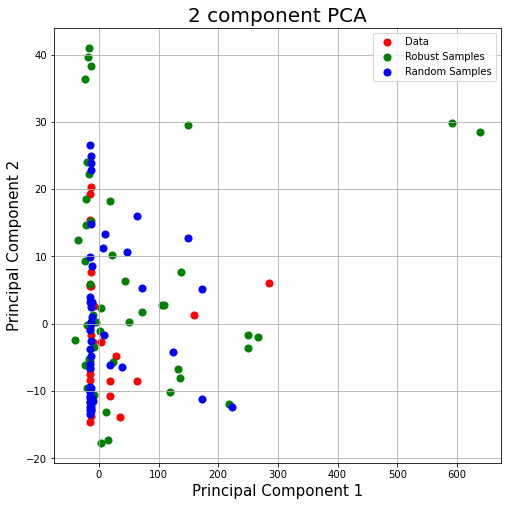

In [41]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Data', 'Robust Samples', 'Random Samples']
datas = [original_data_reduced, transformed_ctgan_pca, transformed_vanilla_pca]
colors = ['r', 'g', 'b']
for data, color in zip(datas,colors):
    ax.scatter(data[:,0]
               , data[:,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()